## PREVENDO O PREÇO DE PRODUTOS COMBUSTIVEIS NO PARANA

In [1]:
# Aqui importamos as bibliotecas que faremos uso
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from darts import TimeSeries
from darts.models import (
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)
from darts.metrics import mape
from darts.utils.missing_values import auto_fillna
from darts.models.forecasting_model import ForecastingModel

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


Você pode encontrar o data-set desse projeto em:
https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil

In [2]:
# Carregando o arquivo
df = pd.read_csv('2004-2019.tsv', sep='\t', header=0, index_col='Unnamed: 0', encoding='utf8')

## Análise Exploratória
Vamos começar explorando e entendendo melhor o nosso dataset. O método head() é sempre uma boa opcão inicial para isso, já que permite uma análise visual da tabela.

In [3]:
df.head()

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


### Describe()
É muito eficiente para entender as métricas do seu data set. Repare que ele traz informações apenas para os seus valores de variáveis numéricas. O ponto importante aqui é que, como vimos no head, as colunas de preço de distribuição deveriam ser métricas, mas não foram computadas aqui, é um sinal que os tipos das variáveis estão inconsistentes. Entretanto, como vamos trabalhar com os valores médios de revenda, não vamos nos preocupar nesse momento em alterar os dtypes dessas colunas.

In [4]:
df.describe()

,NÚMERO DE POSTOS PESQUISADOS,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,COEF DE VARIAÇÃO REVENDA,MÊS,ANO
count,106823.000000,106823.000000,106823.000000,106823.000000,106823.000000,106823.000000,106823.000000,106823.000000
mean,233.770976,10.870780,0.657227,9.416038,12.537731,0.045418,6.484006,2011.802271
std,403.282519,17.752533,1.349169,15.092193,20.841497,0.025066,3.443391,4.391530
min,1.000000,0.766000,0.000000,0.590000,0.999000,0.000000,1.000000,2004.000000
25%,42.000000,2.072000,0.072000,1.900000,2.310000,0.029000,4.000000,2008.000000
50%,104.000000,2.718000,0.114000,2.510000,2.999000,0.041000,6.000000,2012.000000
75%,243.000000,3.752000,0.191000,3.499000,4.150000,0.058000,9.000000,2016.000000
max,4167.000000,99.357000,10.748000,90.000000,120.000000,0.395000,12.000000,2019.000000


## Podemos confirmar isso através da chamada do info()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DATA INICIAL                   106823 non-null  object 
 1   DATA FINAL                     106823 non-null  object 
 2   REGIÃO                         106823 non-null  object 
 3   ESTADO                         106823 non-null  object 
 4   PRODUTO                        106823 non-null  object 
 5   NÚMERO DE POSTOS PESQUISADOS   106823 non-null  int64  
 6   UNIDADE DE MEDIDA              106823 non-null  object 
 7   PREÇO MÉDIO REVENDA            106823 non-null  float64
 8   DESVIO PADRÃO REVENDA          106823 non-null  float64
 9   PREÇO MÍNIMO REVENDA           106823 non-null  float64
 10  PREÇO MÁXIMO REVENDA           106823 non-null  float64
 11  MARGEM MÉDIA REVENDA           106823 non-null  object 
 12  COEF DE VARIAÇÃO REVENDA      

Aqui vemos que as colunas de preço médio estão como string e nossas coluans de data também. Faremos a transformação apenas das colunas de data já que trabalharemos com o preço de revenda e nao o preço de distribuição.

Também observe que como temos 106.823 entradas e 106.823 non-null values em todas as colunas, significa que não temos  nulls nas colunas da base, então não precisaremos tratar para esse caso.

In [6]:
# Transformando as datas para datetime.

df['DATA INICIAL'] = df['DATA INICIAL'].astype('datetime64[ns]')
df['DATA FINAL'] = df['DATA FINAL'].astype('datetime64[ns]')

In [7]:
df.dtypes

DATA INICIAL                     datetime64[ns]
DATA FINAL                       datetime64[ns]
REGIÃO                                   object
ESTADO                                   object
PRODUTO                                  object
NÚMERO DE POSTOS PESQUISADOS              int64
UNIDADE DE MEDIDA                        object
PREÇO MÉDIO REVENDA                     float64
DESVIO PADRÃO REVENDA                   float64
PREÇO MÍNIMO REVENDA                    float64
PREÇO MÁXIMO REVENDA                    float64
MARGEM MÉDIA REVENDA                     object
COEF DE VARIAÇÃO REVENDA                float64
PREÇO MÉDIO DISTRIBUIÇÃO                 object
DESVIO PADRÃO DISTRIBUIÇÃO               object
PREÇO MÍNIMO DISTRIBUIÇÃO                object
PREÇO MÁXIMO DISTRIBUIÇÃO                object
COEF DE VARIAÇÃO DISTRIBUIÇÃO            object
MÊS                                       int64
ANO                                       int64
dtype: object

### Vamos preparar o nosso dataset para o contexto de prever o preço médio de revenda dos produtos para o paraná.

Vamos filtrar o df apenas para o estado do Paraná e criar o df_pr.

In [8]:
df_pr = df[df["ESTADO"] == 'PARANA']

Depois, vamos entender quais são os produtos que teremos disponíves para analisar no estado do Paraná.

In [9]:
df_pr.PRODUTO.value_counts()

GASOLINA COMUM      785
ETANOL HIDRATADO    785
GLP                 785
ÓLEO DIESEL         785
GNV                 773
ÓLEO DIESEL S10     338
Name: PRODUTO, dtype: int64

Para o propósito do nosso forecasting, vamos escolher a GASOLINA COMUM para trabalhar

In [10]:
# Filtrando os produtos apenas para gasolina comum.
df_pr_gasolina = df_pr[df_pr["PRODUTO"] == 'GASOLINA COMUM']

In [11]:
# Observando o resultado dos nossos filtros.
df_pr_gasolina.head()

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
12088,2004-05-09,2004-05-15,SUL,PARANA,GASOLINA COMUM,767,R$/l,1.966,0.074,1.791,2.50,0.238,0.038,1.728,0.04,1.5101,1.9589,0.023,5,2004
12115,2004-05-16,2004-05-22,SUL,PARANA,GASOLINA COMUM,773,R$/l,1.961,0.079,1.749,2.50,0.232,0.040,1.729,0.041,1.565,2.0075,0.024,5,2004
12142,2004-05-23,2004-05-29,SUL,PARANA,GASOLINA COMUM,775,R$/l,1.963,0.090,1.720,2.50,0.227,0.046,1.736,0.041,1.5127,1.94,0.024,5,2004
12169,2004-05-30,2004-06-05,SUL,PARANA,GASOLINA COMUM,771,R$/l,1.993,0.061,1.780,2.45,0.246,0.031,1.747,0.046,1.65,1.998,0.026,5,2004
12196,2004-06-06,2004-06-12,SUL,PARANA,GASOLINA COMUM,752,R$/l,2.001,0.073,1.799,2.50,0.243,0.036,1.758,0.041,1.646,1.979,0.023,6,2004


In [12]:
# Esse comando é mto importante para termos noção do tamanho do nosso dataset.
df_pr_gasolina.shape

(785, 20)

In [13]:
# Aqui vemos que a nossa última data é de junho de 2019.
df_pr_gasolina["DATA INICIAL"].max()

Timestamp('2019-06-23 00:00:00')

#### Aqui observamos que nossa granularidade de data é semanal, é importante sabermos dessa informação, principalmente para entendermos a frequência e analisar os resíduos e também o ACF que veremos á frente.

In [14]:
df_pr_gasolina["DATA INICIAL"]

12088    2004-05-09
12115    2004-05-16
12142    2004-05-23
12169    2004-05-30
12196    2004-06-06
            ...    
106171   2019-05-26
106320   2019-06-02
106470   2019-06-09
106620   2019-06-16
106769   2019-06-23
Name: DATA INICIAL, Length: 785, dtype: datetime64[ns]

## Vamos supor um problema prático aqui, que poderia ser aplicado num contexto empresarial. 

Digamos que estamos no primeiro trimestre de 2019 e queremos prever como será o segundo semestre, por uma demanda do seu chefe, etc. (Logo vamos supor que não conhecemos o segundo semestre de 2019, para tornar esse o desafio).

## Nesse cenário, precisaremos:
1 - Dividir nosso dataset em 3 partes: O de treino, o de teste, e o de validação.
    O de treino, como o nome diz, usaremos para dar o fit do nosso modelo e treiná-lo.
    O de teste, usaremos para avaliar quão bem o nosso modelo deu fit nos dados, e utilizaremos uma função custo para avaliar e escolher o melhor modelo.
    O de validação, que é o nosso desafio aqui, utilizado para encontrar qual seria nossa performance no avanço dos preços no horizonte dos próximos 3 meses.
    
2 - Depois dos splits da timeseries, aplicaremos alguns modelos nos dados de treino e testaremos eles nos dados de teste.

3 - Definiremos uma função de custo, que é um valor numérico que utilizaremos para escolher o melhor modelo com base nele.

4 - Iremos fazer uma otimização de hiperparâmetros, utilizando a função gridsearch.

5 - Com o modelo otimizado, iremos avaliar ele nos dados de validação, traremos novamente a métrica de erro e iremos observar graficamente o quão bem performamos.

Vamos lá!

### Mas antes de tudo, vamos avaliar o nosso contexto temporal.
Vamos avaliar graficamente como foi o avanço do preço de 2004 até 2020

<AxesSubplot:xlabel='DATA INICIAL', ylabel='PREÇO MÉDIO REVENDA'>

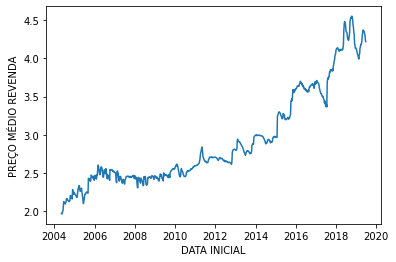

In [15]:
sns.lineplot(x='DATA INICIAL',
         y='PREÇO MÉDIO REVENDA',
        data=df_pr_gasolina)

Vimos que os dados são consistentes (não temos buracos na série) e que notamos uma curva em ascenção.

Agora, para treinarmos nosso modelo, vamos criar um timeseries do darts de teste, e na sequencia setar os split de treino e validação.

####  Esse 'series' é o objeto principal da biblioteca udarts. Precisamos setar ele para depois criar as séries de treino, teste e validação a partir dele.

In [16]:
# Criando o objeto series
series = auto_fillna((TimeSeries.from_dataframe(df_pr_gasolina, 'DATA INICIAL', 'PREÇO MÉDIO REVENDA')))

# Criando as partições de treino, teste, e val.
train, teste = series.drop_after(pd.Timestamp('20190301')).split_after(pd.Timestamp('20190101'))

val = series.drop_before(pd.Timestamp('20190301'))

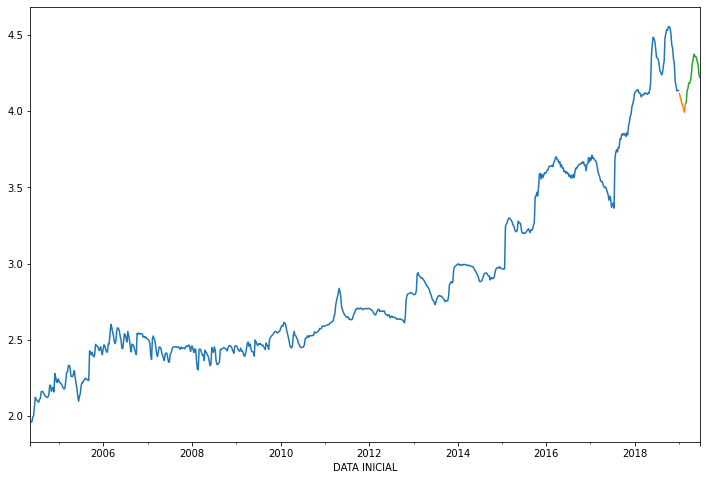

In [17]:
# Aqui podemos avaliar graficamente como ficaram nossas separações.
train.plot(figsize = (12, 8))
teste.plot()
val.plot()

Observe que o comportamento antes de 2010 parece muito diferente do que temos nos valores mais recentes.
Aqui é uma decisão pessoal, eu vou optar por pegar apenas os dados depois de 2017, mas a ideia é remover do treino essa parte que observamos ser muito diferente dos valores atuais, já que o modelo levará esses dados muito antigos em consideração. Dessa forma, vamos tratar novamente o dado de treino, removendo tudo antes de 2017.

In [18]:
# Pegando valores apenas de 2017 para frente:
train = train.drop_before(pd.Timestamp('20170301'))

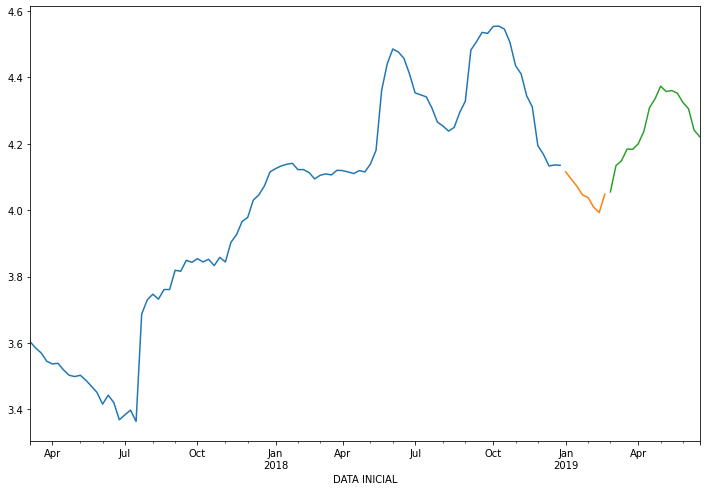

In [19]:
# Avaliando novamente o gráfico
train.plot(figsize = (12, 8))
teste.plot()
val.plot()

Agora que temos as séries, vamos chamar alguns modelos e avaliar como eles se comportam nos nossos dados de teste, depois de treiná-los nos dados de teste

### Com base na função custo, vamos escolher o modelo que apresenta o menor erro. No nosso caso, o menor MAPE.

In [20]:
# Lista de modelos escolhidos para avaliarmos.
models = [
    AutoARIMA(),
    Prophet(),
    ExponentialSmoothing(),
    Theta(),
    FFT()
]

# Para cada modelo, iremos avaliar a função de custo, nesse caso a função eh a MAPE. (Mean Absolute Percentage Error)

for model in models:
    
    #treinando o modelo.
    model.fit(train)
    
    # criando as previsões.
    pred_teste = model.predict(len(teste))
    
    #printando o resultado e o modelo.
    print(str(model) + " MAPE: " + str(mape(pred_teste, teste)))

Auto-ARIMA MAPE: 2.0228816915712735
Prophet MAPE: 6.046883589435064
Exponential smoothing MAPE: 0.6733601245648227
Theta(0) MAPE: 2.6106738667092766
FFT(nr_freqs_to_keep=10, trend=None) MAPE: 11.561956028693842


O Exponential Smoothing apresentou o menor MAPE e vamos prosseguir com ele. O que faremos na sequência vai ser o processo de otimização dos hiperparâmetros desse modelo.

Pela própria documentação do u8darts sobre exponential Smoothing, podemos ver que temos os seguintes hiperparâmetros para otimizar:

        Parameters
        ----------
        trend
            Type of trend component. Either ModelMode.ADDITIVE or ModelMode.MULTIPLICATIVE.
            Defaults to `ModelMode.ADDITIVE`.
        damped
            Should the trend component be damped. Defaults to False.
        seasonal
            Type of seasonal component. Either ModelMode.ADDITIVE or ModelMode.MULTIPLICATIVE.
            Defaults to `ModelMode.ADDITIVE`.
        seasonal_periods
            The number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily
            data with a weekly cycle.
            
font: https://github.com/unit8co/darts/blob/master/darts/models/exponential_smoothing.py

Vamos inicialmente criar um dict com os parâmetros que iremos avaliar.

In [21]:
dict_params = {
    'seasonal': ['additive', 'multiplicative'],
    'damped': [True, False],
    'trend': ['additive', 'multiplicative'],
    'seasonal_periods': [7, 14, 21, 28]
}

A biblioteca itertools fará uma iteração e vai criar todas as possibilidades de combinação no dicionário. Isso é importante pois usaremos o dicionário final como parâmetro de otimização do gridsearch.

In [22]:
import itertools
keys, values = zip(*dict_params.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [23]:
# Otimizando o Exponential smoothing:
model_exp_smo = ExponentialSmoothing(seasonal='additive', damped=False, trend='additive', seasonal_periods=7)
model_exp_smo.fit(train)
exp_smo_pred = model_exp_smo.predict(len(teste))
print(str(model_exp_smo) + " MAPE: " + str(mape(exp_smo_pred, teste)))

Exponential smoothing MAPE: 0.48920128315089123


In [24]:
for i in permutations_dicts:
    model_exp_smo = ExponentialSmoothing(seasonal=i['seasonal'], damped=i['damped'], trend=i['trend'], seasonal_periods=i['seasonal_periods'])
    model_exp_smo.fit(train)
    exp_smo_pred = model_exp_smo.predict(len(teste))
    print(" MAPE: " + str(mape(exp_smo_pred, teste)), str(i))

 MAPE: 1.7714158266789677 {'seasonal': 'additive', 'damped': True, 'trend': 'additive', 'seasonal_periods': 7}
 MAPE: 1.518370632505204 {'seasonal': 'additive', 'damped': True, 'trend': 'additive', 'seasonal_periods': 14}
 MAPE: 2.5196219820513885 {'seasonal': 'additive', 'damped': True, 'trend': 'additive', 'seasonal_periods': 21}
 MAPE: 0.9542597017210098 {'seasonal': 'additive', 'damped': True, 'trend': 'additive', 'seasonal_periods': 28}
 MAPE: 6.069188318540059 {'seasonal': 'additive', 'damped': True, 'trend': 'multiplicative', 'seasonal_periods': 7}
 MAPE: 5.352853470571773 {'seasonal': 'additive', 'damped': True, 'trend': 'multiplicative', 'seasonal_periods': 14}
 MAPE: 6.428575230294757 {'seasonal': 'additive', 'damped': True, 'trend': 'multiplicative', 'seasonal_periods': 21}
 MAPE: 4.962584902861014 {'seasonal': 'additive', 'damped': True, 'trend': 'multiplicative', 'seasonal_periods': 28}
 MAPE: 0.48920128315089123 {'seasonal': 'additive', 'damped': False, 'trend': 'additive

Acima rodamos todas as possibilidades do gridSearch. Fiz dessa forma para que ficasse ilustrados as possibilidades e também os erros, dessa forma, veja que a combinação com o menor MAPE foi a:

MAPE: 0.4775871073401454 {'seasonal': 'multiplicative', 'damped': False, 'trend': 'additive', 'seasonal_periods': 7}

Sendo assim, vamos chamar nosso modelo novamente, com esses hiperparametros:

In [25]:
# Otimizando o Exponential smoothing:
model_exp_smo = ExponentialSmoothing(seasonal='multiplicative', damped=False, trend='additive', seasonal_periods=7)
model_exp_smo.fit(train)
exp_smo_pred = model_exp_smo.predict(len(teste))
print(str(model_exp_smo) + " MAPE: " + str(mape(exp_smo_pred, teste)))

Exponential smoothing MAPE: 0.4775871073401454


### Com nosso modelo otimizado, podemos analisar os nossos resíduos

In [26]:
# Iniciando a montagem do df com os dados reais e dados previsto pelo Exponential Smoothing

# Começamos chamando os dados de teste
df_with_predict = teste.pd_dataframe()

# Adicionamos a coluna dos predictions do modelo Exponential Smoothing
df_with_predict['prediction'] = exp_smo_pred.pd_dataframe()

# Renomeamos as colunas para ficar mais claro
df_with_predict.columns = ['real', 'prediction']

# Criamos o resíduo, que é a diferença entre o real e o previsto.
df_with_predict['residuals'] = df_with_predict.real - df_with_predict.prediction

df_with_predict

,real,prediction,residuals
DATA INICIAL,,,
2019-01-06,4.115,4.100857,0.014143
2019-01-13,4.093,4.091189,0.001811
2019-01-20,4.072,4.078258,-0.006258
2019-01-27,4.046,4.061054,-0.015054
2019-02-03,4.038,4.037696,0.000304
2019-02-10,4.009,4.008077,0.000923
2019-02-17,3.993,3.980520,0.012480
2019-02-24,4.048,3.946830,0.101170


Primeiro vamos avaliar se os resíduos apresentam uma média zero. Ou seja, não temos uma tendência para cima ou para baixo no modelo.

In [27]:
# Média Zero?
df_with_predict['residuals'].mean()

0.013690023014016228

<AxesSubplot:ylabel='Frequency'>

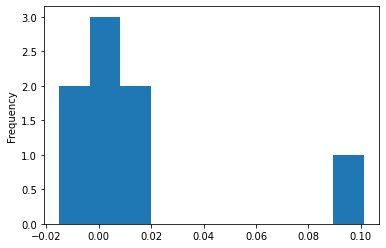

In [28]:
# Distribuição do erro.
df_with_predict['residuals'].plot(kind='hist')

Veja que nosso erro fica em torno de zero, como esperávamos, com alguns valores positivos e outros negativos. Sendo assim, vamos prosseguir para a etapa de aplicar nosso modelo no real, que chamamos aqui de `val`, e ver como teríamos performado

In [29]:
# Recriando as partições de treino e val.
train, val = series.split_after(pd.Timestamp('20190301'))

train = train.drop_before(pd.Timestamp('20170301'))

val = series.drop_before(pd.Timestamp('20190301'))

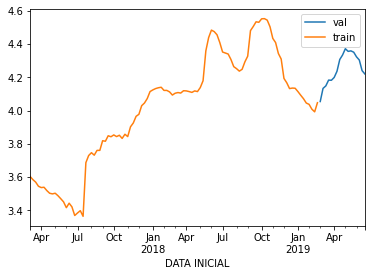

In [30]:
# Avaliando que o val  e o treino está no período que desejamos
val.plot(label='val')
train.plot(label='train')
plt.legend()

Estando tudo correto, vamos fazer nossa previsão final, e ver como teríamos performado:

In [31]:
# Modelo final:
model_exp_smo = ExponentialSmoothing(seasonal='multiplicative', damped=False, trend='additive', seasonal_periods=7)
model_exp_smo.fit(train)
exp_smo_pred = model_exp_smo.predict(len(val))
print(str(model_exp_smo) + " MAPE: " + str(mape(exp_smo_pred, val)))

Exponential smoothing MAPE: 3.9139790455237558


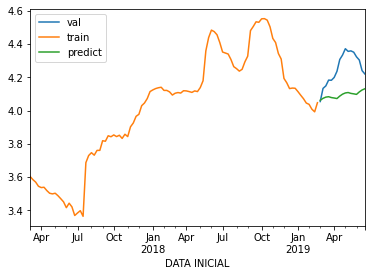

In [32]:
# Avaliando nosso resultado final:
val.plot(label='val')
train.plot(label='train')
exp_smo_pred.plot(label='predict')
plt.legend()

Mesmo com um bom desempenho nos dados de teste, ficamos com um gap relevante versus os valores que realmente ocorreram. Essa série era de fato desafiadora, dado o cenário imprevisível que ocorreu na viarada em fevereiro e depois outra queda em maio. Além disso, estávamos prevendo um horizonte grande no futuro.

De qualquer forma, esse estudo foi como teríamos performado em um horizonte grande de valores bem como toda a lógica da implementação da biblioteca, e também nos mostra como nem sempre a realidade é tão previsível.